In [5]:
!pip install ultralytics opencv-python matplotlib seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [6]:
import ultralytics
import os
import shutil
import random
import yaml
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO
import numpy as np
from sklearn.model_selection import train_test_split

ultralytics.checks()

Ultralytics 8.3.159 🚀 Python-3.13.4 torch-2.7.1 CPU (Apple M1 Max)
Setup complete ✅ (10 CPUs, 32.0 GB RAM, 294.8/460.4 GB disk)


In [13]:
# Import class names from existing YAML file
def load_class_names_from_yaml(yaml_path):
    """Load class names from existing data.yaml file."""
    if os.path.exists(yaml_path):
        with open(yaml_path, 'r') as f:
            data = yaml.safe_load(f)

        class_names = data.get('names', [])
        if isinstance(class_names, dict):
            # If names is a dictionary (class_id: class_name), convert to list
            class_names = [class_names[i] for i in sorted(class_names.keys())]
        elif isinstance(class_names, list):
            # If names is already a list, use as is
            pass
        else:
            raise ValueError("Class names in YAML should be either a list or dictionary")

        # Validate class names
        if not class_names:
            raise ValueError("No class names found in YAML file")

        # Check for valid class names (no empty strings)
        class_names = [str(name).strip() for name in class_names if str(name).strip()]

        print(f"Loaded {len(class_names)} class names from {yaml_path}")
        print(f"Classes: {class_names}")
        return class_names
    else:
        raise FileNotFoundError(f"YAML file not found: {yaml_path}")

def validate_yaml_structure(yaml_path):
    """Validate the structure of a YAML file for YOLOv8 compatibility."""
    try:
        with open(yaml_path, 'r') as f:
            data = yaml.safe_load(f)

        required_keys = ['names']
        optional_keys = ['path', 'train', 'val', 'test', 'nc']

        missing_keys = [key for key in required_keys if key not in data]
        if missing_keys:
            print(f"Warning: Missing required keys in YAML: {missing_keys}")

        present_keys = [key for key in optional_keys if key in data]
        print(f"Present optional keys: {present_keys}")

        # Validate nc matches number of names
        if 'nc' in data and 'names' in data:
            names = data['names']
            if isinstance(names, list):
                expected_nc = len(names)
            elif isinstance(names, dict):
                expected_nc = len(names)
            else:
                expected_nc = 0

            if data['nc'] != expected_nc:
                print(f"Warning: 'nc' ({data['nc']}) doesn't match number of class names ({expected_nc})")

        return True
    except Exception as e:
        print(f"Error validating YAML: {e}")
        return False

# Dataset configuration
DATASET_PATH = "data/YOLO-Bulk"  # Your dataset path
OUTPUT_PATH = "yolo_dataset_split"
YAML_CONFIG_PATH = "data/YOLO-Bulk/data.yaml"  # Path to your existing data.yaml file

# Load class names from YAML file
try:
    # First validate the YAML structure
    if os.path.exists(YAML_CONFIG_PATH):
        print("Validating YAML file structure...")
        validate_yaml_structure(YAML_CONFIG_PATH)

    CLASS_NAMES = load_class_names_from_yaml(YAML_CONFIG_PATH)
except FileNotFoundError:
    print(f"Warning: {YAML_CONFIG_PATH} not found. Using default class names.")
    CLASS_NAMES = ["class1", "class2", "class3"]  # Fallback default classes
except Exception as e:
    print(f"Error loading YAML: {e}")
    print("Using default class names.")
    CLASS_NAMES = ["class1", "class2", "class3"]  # Fallback default classes

# Split ratios
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Training configuration
MODEL_SIZE = "yolov8n.pt"  # Options: yolov8n.pt, yolov8s.pt, yolov8m.pt, yolov8l.pt, yolov8x.pt
EPOCHS = 100
IMAGE_SIZE = 640
BATCH_SIZE = 16

print(f"Train: {TRAIN_RATIO*100}%, Val: {VAL_RATIO*100}%, Test: {TEST_RATIO*100}%")
print(f"Number of classes: {len(CLASS_NAMES)}")

Validating YAML file structure...
Present optional keys: ['nc']
Loaded 26 class names from data/YOLO-Bulk/data.yaml
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Train: 70.0%, Val: 15.0%, Test: 15.0%
Number of classes: 26


In [14]:
def inspect_yaml_file(yaml_path):
    """Inspect and display the contents of a YAML configuration file."""
    if not os.path.exists(yaml_path):
        print(f"YAML file not found: {yaml_path}")
        return None

    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)

    print("YAML File Contents:")
    print("=" * 50)
    for key, value in data.items():
        print(f"{key}: {value}")

    return data

def create_sample_yaml():
    """Create a sample data.yaml file structure for reference."""
    sample_yaml = """
# Example data.yaml structure:

# Option 1: Class names as a list (most common)
path: /path/to/dataset
train: train/images
val: val/images
test: test/images
nc: 3
names: ['person', 'car', 'bicycle']

# Option 2: Class names as a dictionary (class_id: class_name)
# names:
#   0: person
#   1: car
#   2: bicycle

# Option 3: COCO format example
# names:
#   0: person
#   1: bicycle
#   2: car
#   3: motorcycle
#   # ... up to 79 for COCO

# Common YAML file locations:
# - data.yaml (in project root)
# - datasets/custom/data.yaml
# - path/to/dataset/data.yaml
"""
    print("Sample YAML structure:")
    print(sample_yaml)

def create_example_yaml_files():
    """Create example YAML files for different use cases."""
    # Example 1: Simple 3-class dataset
    example1 = {
        'path': '/path/to/dataset',
        'train': 'train/images',
        'val': 'val/images',
        'test': 'test/images',
        'nc': 3,
        'names': ['person', 'car', 'bicycle']
    }

    with open('example_data_list.yaml', 'w') as f:
        yaml.dump(example1, f, default_flow_style=False)

    # Example 2: Dictionary format
    example2 = {
        'path': '/path/to/dataset',
        'train': 'train/images',
        'val': 'val/images',
        'test': 'test/images',
        'nc': 3,
        'names': {0: 'person', 1: 'car', 2: 'bicycle'}
    }

    with open('example_data_dict.yaml', 'w') as f:
        yaml.dump(example2, f, default_flow_style=False)

    print("Created example YAML files:")
    print("- example_data_list.yaml (list format)")
    print("- example_data_dict.yaml (dictionary format)")

# Uncomment the next line to create example YAML files
# create_example_yaml_files()

# Inspect existing YAML file
print("Checking your data.yaml file...")
if os.path.exists(YAML_CONFIG_PATH):
    yaml_data = inspect_yaml_file(YAML_CONFIG_PATH)
    print("\nValidating YAML structure...")
    validate_yaml_structure(YAML_CONFIG_PATH)
else:
    print(f"YAML file '{YAML_CONFIG_PATH}' not found.")
    print("Expected location: /data/YOLO-Bulk/data.yaml")
    create_sample_yaml()

Checking your data.yaml file...
YAML File Contents:
nc: 26
names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
roboflow: {'workspace': 'david-lee-d0rhs', 'project': 'american-sign-language-letters', 'version': 1, 'license': 'Public Domain', 'url': 'https://universe.roboflow.com/david-lee-d0rhs/american-sign-language-letters/dataset/1'}

Validating YAML structure...
Present optional keys: ['nc']


In [15]:
def analyze_dataset(dataset_path):
    """Analyze the original dataset structure and content."""
    print("Dataset Analysis:")
    print("=" * 50)

    images_path = os.path.join(dataset_path, "images")
    labels_path = os.path.join(dataset_path, "labels")

    if not os.path.exists(images_path) or not os.path.exists(labels_path):
        print("Error: Expected 'images' and 'labels' folders in dataset path")
        return False

    # Count files
    image_files = [f for f in os.listdir(images_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    label_files = [f for f in os.listdir(labels_path) if f.lower().endswith('.txt')]

    print(f"Images found: {len(image_files)}")
    print(f"Labels found: {len(label_files)}")

    # Check for matching files
    image_names = {os.path.splitext(f)[0] for f in image_files}
    label_names = {os.path.splitext(f)[0] for f in label_files}

    matched = len(image_names.intersection(label_names))
    unmatched_images = len(image_names - label_names)
    unmatched_labels = len(label_names - image_names)

    print(f"Matched image-label pairs: {matched}")
    print(f"Images without labels: {unmatched_images}")
    print(f"Labels without images: {unmatched_labels}")

    return True

# Analyze the dataset
analyze_dataset(DATASET_PATH)

Dataset Analysis:
Images found: 1728
Labels found: 1728
Matched image-label pairs: 1728
Images without labels: 0
Labels without images: 0


True

In [16]:
def create_directory_structure(output_path):
    """Create the directory structure for train/val/test splits."""
    splits = ['train', 'val', 'test']

    for split in splits:
        os.makedirs(os.path.join(output_path, split, 'images'), exist_ok=True)
        os.makedirs(os.path.join(output_path, split, 'labels'), exist_ok=True)

    print(f"Created directory structure at: {output_path}")

def get_matched_files(dataset_path):
    """Get list of files that have both image and label."""
    images_path = os.path.join(dataset_path, "images")
    labels_path = os.path.join(dataset_path, "labels")

    if not os.path.exists(images_path) or not os.path.exists(labels_path):
        raise FileNotFoundError(f"Images or labels directory not found in {dataset_path}")

    # Get all image files with multiple extensions
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif')
    image_files = []
    for ext in image_extensions:
        image_files.extend([f for f in os.listdir(images_path) if f.lower().endswith(ext)])

    print(f"Found {len(image_files)} image files")

    # Filter to only those with corresponding labels
    matched_files = []
    missing_labels = []

    for img_file in image_files:
        base_name = os.path.splitext(img_file)[0]
        label_file = base_name + '.txt'

        img_path = os.path.join(images_path, img_file)
        label_path = os.path.join(labels_path, label_file)

        if os.path.exists(label_path):
            matched_files.append((img_path, label_path, base_name, img_file))
        else:
            missing_labels.append(img_file)

    if missing_labels:
        print(f"Warning: {len(missing_labels)} images don't have corresponding labels")
        if len(missing_labels) <= 10:
            print(f"Missing labels for: {missing_labels}")
        else:
            print(f"First 10 missing labels: {missing_labels[:10]}")

    print(f"Matched image-label pairs: {len(matched_files)}")
    return matched_files

def split_dataset(matched_files, train_ratio, val_ratio, test_ratio):
    """Split the dataset into train/val/test sets."""
    random.shuffle(matched_files)

    total_files = len(matched_files)
    train_count = int(total_files * train_ratio)
    val_count = int(total_files * val_ratio)

    train_files = matched_files[:train_count]
    val_files = matched_files[train_count:train_count + val_count]
    test_files = matched_files[train_count + val_count:]

    print(f"Split summary:")
    print(f"Train: {len(train_files)} files ({len(train_files)/total_files*100:.1f}%)")
    print(f"Val: {len(val_files)} files ({len(val_files)/total_files*100:.1f}%)")
    print(f"Test: {len(test_files)} files ({len(test_files)/total_files*100:.1f}%)")

    return train_files, val_files, test_files

def copy_files(file_list, output_path, split_name):
    """Copy files to the appropriate split directory."""
    for img_path, label_path, base_name, img_filename in file_list:
        # Copy image (preserve original extension)
        img_ext = os.path.splitext(img_filename)[1]
        new_img_path = os.path.join(output_path, split_name, 'images', base_name + img_ext)
        shutil.copy2(img_path, new_img_path)

        # Copy label
        new_label_path = os.path.join(output_path, split_name, 'labels', base_name + '.txt')
        shutil.copy2(label_path, new_label_path)

    print(f"Copied {len(file_list)} files to {split_name} split")

In [17]:
print("Your dataset structure:")
print("/data/YOLO-Bulk/")
print("├── data.yaml")
print("├── images/")
print("└── labels/")
print()
print("After splitting, the new structure will be:")
print("yolo_dataset_split/")
print("├── dataset.yaml")
print("├── train/")
print("│   ├── images/")
print("│   └── labels/")
print("├── val/")
print("│   ├── images/")
print("│   └── labels/")
print("└── test/")
print("    ├── images/")
print("    └── labels/")
print()
create_directory_structure(OUTPUT_PATH)

matched_files = get_matched_files(DATASET_PATH)

if len(matched_files) == 0:
    print("Error: No matched image-label pairs found!")
    print("Please check that:")
    print("1. Images are in /data/YOLO-Bulk/images/")
    print("2. Labels are in /data/YOLO-Bulk/labels/")
    print("3. Image and label files have matching names (except extensions)")
else:
    print(f"Ready to split {len(matched_files)} matched image-label pairs")

    # Split the dataset
    train_files, val_files, test_files = split_dataset(
        matched_files, TRAIN_RATIO, VAL_RATIO, TEST_RATIO
    )

    # Copy files to respective directories
    copy_files(train_files, OUTPUT_PATH, 'train')
    copy_files(val_files, OUTPUT_PATH, 'val')
    copy_files(test_files, OUTPUT_PATH, 'test')

    print("\n" + "="*50)
    print("DATASET SPLIT COMPLETED SUCCESSFULLY!")
    print("="*50)
    print(f"Original dataset: {DATASET_PATH}")
    print(f"Split dataset: {OUTPUT_PATH}")
    print(f"Total files processed: {len(matched_files)}")

Your dataset structure:
/data/YOLO-Bulk/
├── data.yaml
├── images/
└── labels/

After splitting, the new structure will be:
yolo_dataset_split/
├── dataset.yaml
├── train/
│   ├── images/
│   └── labels/
├── val/
│   ├── images/
│   └── labels/
└── test/
    ├── images/
    └── labels/

Created directory structure at: yolo_dataset_split
Found 1728 image files
Matched image-label pairs: 1728
Ready to split 1728 matched image-label pairs
Split summary:
Train: 1209 files (70.0%)
Val: 259 files (15.0%)
Test: 260 files (15.0%)
Copied 1209 files to train split
Copied 259 files to val split
Copied 260 files to test split

DATASET SPLIT COMPLETED SUCCESSFULLY!
Original dataset: data/YOLO-Bulk
Split dataset: yolo_dataset_split
Total files processed: 1728


In [18]:
def create_yaml_config(output_path, class_names, base_yaml_path=None):
    """Create YAML configuration file for YOLOv8."""
    # Start with base configuration if provided
    config = {}
    if base_yaml_path and os.path.exists(base_yaml_path):
        with open(base_yaml_path, 'r') as f:
            config = yaml.safe_load(f) or {}
        print(f"Using base configuration from: {base_yaml_path}")

    # Update with new paths and class information
    config.update({
        'path': os.path.abspath(output_path),
        'train': 'train/images',
        'val': 'val/images',
        'test': 'test/images',
        'nc': len(class_names),
        'names': class_names
    })

    yaml_path = os.path.join(output_path, 'dataset.yaml')

    with open(yaml_path, 'w') as f:
        yaml.dump(config, f, default_flow_style=False)

    print(f"Created YAML config at: {yaml_path}")
    return yaml_path

# Create YAML configuration, optionally using existing YAML as base
yaml_config_path = create_yaml_config(OUTPUT_PATH, CLASS_NAMES, YAML_CONFIG_PATH if os.path.exists(YAML_CONFIG_PATH) else None)

# Display the config
with open(yaml_config_path, 'r') as f:
    print("\nDataset configuration:")
    print(f.read())

Using base configuration from: data/YOLO-Bulk/data.yaml
Created YAML config at: yolo_dataset_split/dataset.yaml

Dataset configuration:
names:
- A
- B
- C
- D
- E
- F
- G
- H
- I
- J
- K
- L
- M
- N
- O
- P
- Q
- R
- S
- T
- U
- V
- W
- X
- Y
- Z
nc: 26
path: /Users/kjasman/Documents/Summer2025/SENG474/Project/ASL-Fingerspelling/yolo_dataset_split
roboflow:
  license: Public Domain
  project: american-sign-language-letters
  url: https://universe.roboflow.com/david-lee-d0rhs/american-sign-language-letters/dataset/1
  version: 1
  workspace: david-lee-d0rhs
test: test/images
train: train/images
val: val/images




Sample images from train set:


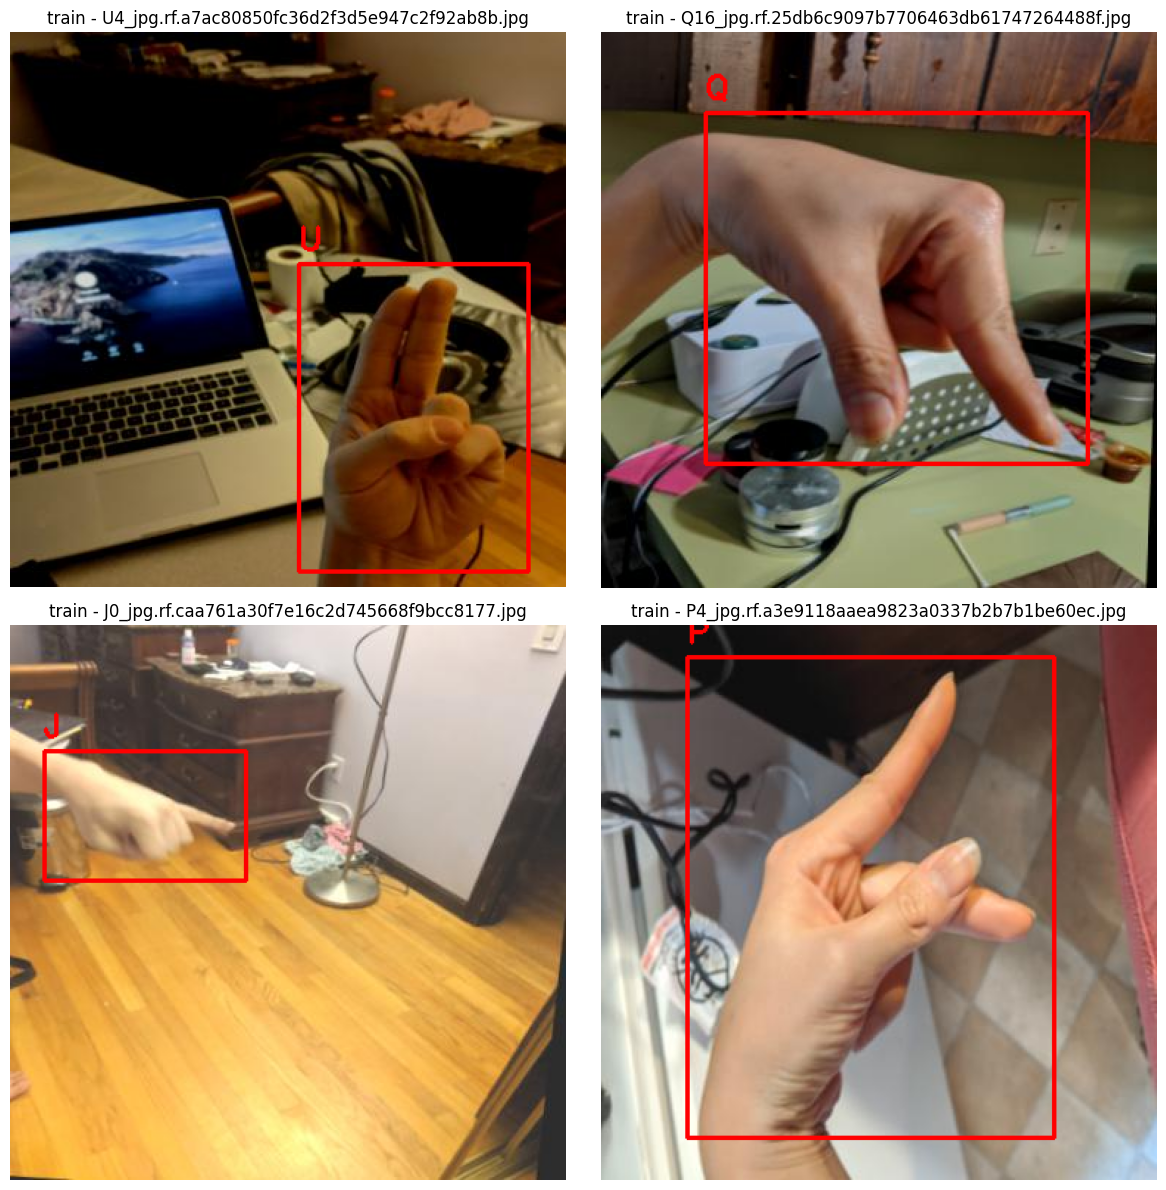


Sample images from val set:


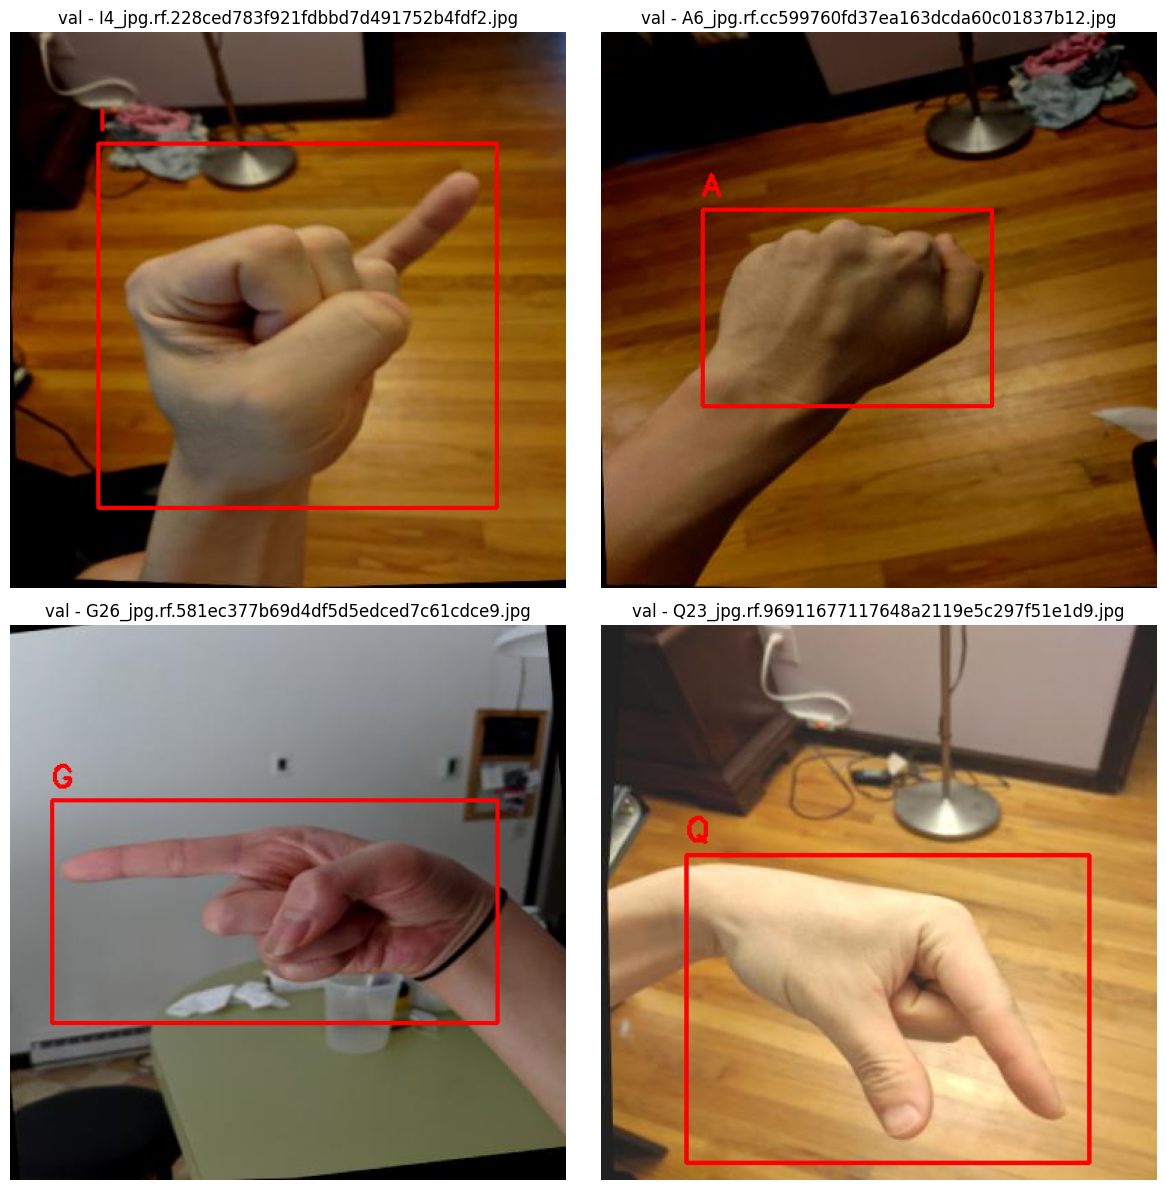


Sample images from test set:


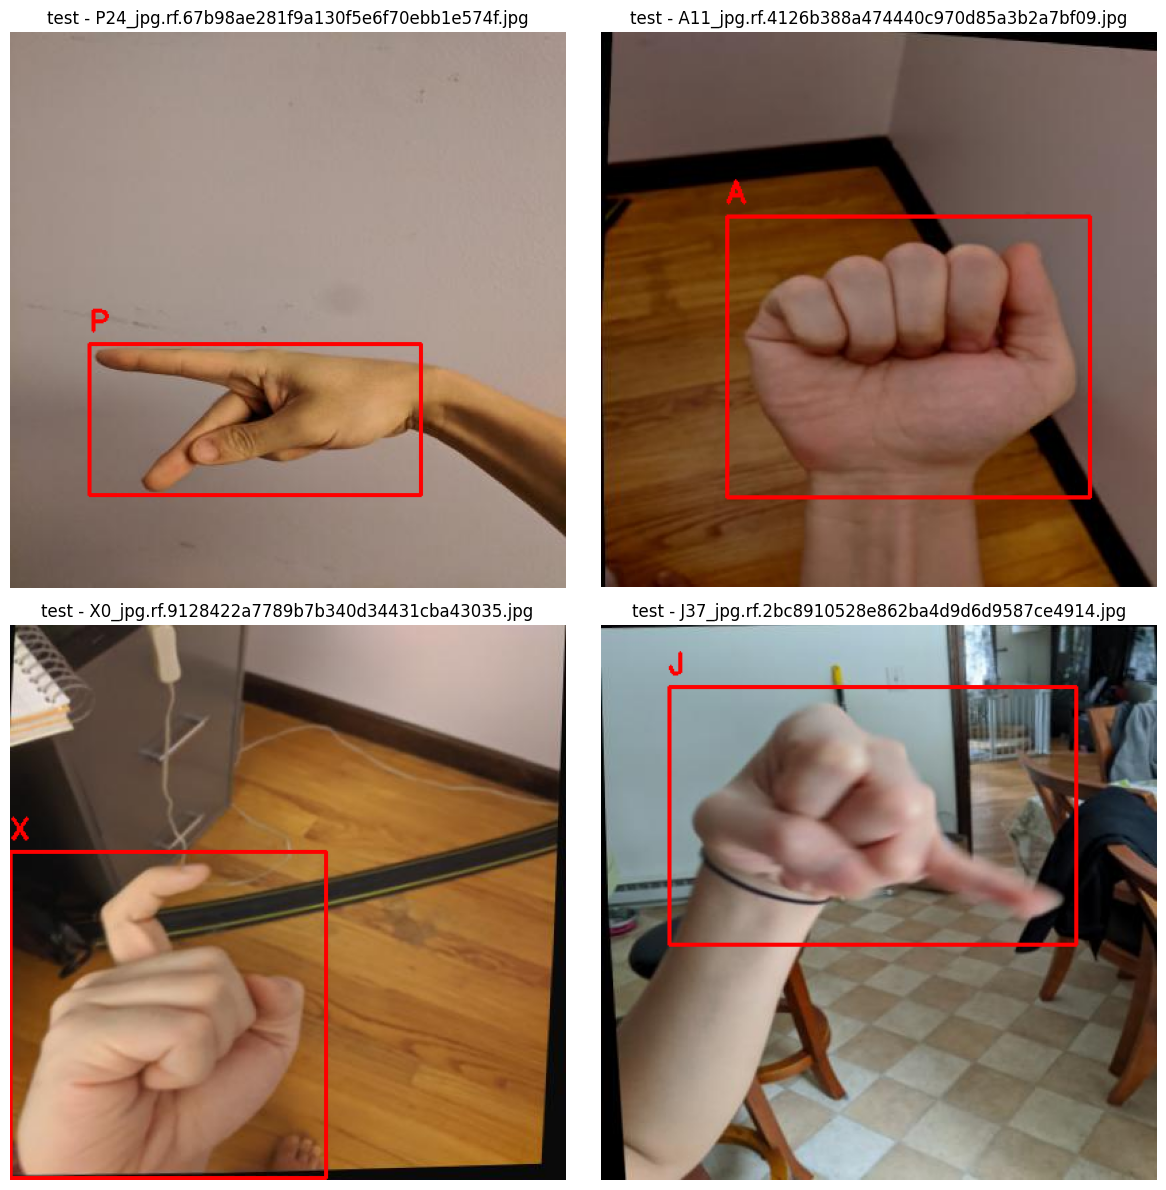

In [19]:
def visualize_samples(output_path, split='train', num_samples=4):
    """Visualize sample images with their annotations."""
    images_dir = os.path.join(output_path, split, 'images')
    labels_dir = os.path.join(output_path, split, 'labels')

    image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    sample_files = random.sample(image_files, min(num_samples, len(image_files)))

    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.ravel()

    for idx, img_file in enumerate(sample_files):
        if idx >= 4:
            break

        # Load image
        img_path = os.path.join(images_dir, img_file)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w = image.shape[:2]

        # Load annotations
        base_name = os.path.splitext(img_file)[0]
        label_path = os.path.join(labels_dir, base_name + '.txt')

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()

            for line in lines:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id, x_center, y_center, width, height = map(float, parts)

                    # Convert to pixel coordinates
                    x_center *= w
                    y_center *= h
                    width *= w
                    height *= h

                    # Draw bounding box
                    x1 = int(x_center - width/2)
                    y1 = int(y_center - height/2)
                    x2 = int(x_center + width/2)
                    y2 = int(y_center + height/2)

                    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

                    # Add class label
                    if int(class_id) < len(CLASS_NAMES):
                        label = CLASS_NAMES[int(class_id)]
                        cv2.putText(image, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

        axes[idx].imshow(image)
        axes[idx].set_title(f'{split} - {img_file}')
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize samples from each split
for split in ['train', 'val', 'test']:
    print(f"\nSample images from {split} set:")
    visualize_samples(OUTPUT_PATH, split)

In [ ]:
def train_yolo_model(yaml_config_path, model_size, epochs, image_size, batch_size):
    """Train YOLOv8 model."""
    print(f"Starting training with {model_size}")
    print(f"Configuration: epochs={epochs}, image_size={image_size}, batch_size={batch_size}")

    # Load model
    model = YOLO(model_size)

    # Train the model
    results = model.train(
        data=yaml_config_path,
        epochs=epochs,
        imgsz=image_size,
        batch=batch_size,
        save=True,
        project='yolo_training',
        name='custom_model',
        patience=20,
        save_period=10
    )

    return model, results

# Start training
print("Initializing model training...")
model, training_results = train_yolo_model(
    yaml_config_path, MODEL_SIZE, EPOCHS, IMAGE_SIZE, BATCH_SIZE
)

print("Training completed!")

Initializing model training...
Starting training with yolov8n.pt
Configuration: epochs=100, image_size=640, batch_size=16


100%|██████████| 6.25M/6.25M [00:00<00:00, 19.7MB/s]


Ultralytics 8.3.159 🚀 Python-3.13.4 torch-2.7.1 CPU (Apple M1 Max)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset_split/dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=custom_model, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose=12.0, pretrained=True, 

In [ ]:
def validate_model(model, yaml_config_path):
    """Validate the trained model."""
    print("Running validation...")

    # Validate on validation set
    val_results = model.val(data=yaml_config_path)

    print(f"mAP50: {val_results.box.map50:.4f}")
    print(f"mAP50-95: {val_results.box.map:.4f}")

    return val_results

def test_model(model, test_images_path):
    """Test the model on test set."""
    print("Running inference on test set...")

    test_results = model.predict(
        source=test_images_path,
        save=True,
        project='yolo_testing',
        name='test_results',
        conf=0.25,
        iou=0.45
    )

    return test_results

# Validate the model
validation_results = validate_model(model, yaml_config_path)

# Test on test set
test_images_path = os.path.join(OUTPUT_PATH, 'test', 'images')
test_results = test_model(model, test_images_path)

0

In [20]:
def plot_training_results():
    """Plot training metrics from the results."""
    # The training results are typically saved in runs/detect/train/
    results_dir = 'yolo_training/custom_model'

    if os.path.exists(os.path.join(results_dir, 'results.csv')):
        import pandas as pd

        # Load results
        df = pd.read_csv(os.path.join(results_dir, 'results.csv'))
        df.columns = df.columns.str.strip()  # Remove any whitespace

        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Loss plots
        if 'train/box_loss' in df.columns:
            axes[0, 0].plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
            axes[0, 0].plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
            axes[0, 0].set_title('Box Loss')
            axes[0, 0].set_xlabel('Epoch')
            axes[0, 0].set_ylabel('Loss')
            axes[0, 0].legend()
            axes[0, 0].grid(True)

        # Objectness loss
        if 'train/obj_loss' in df.columns:
            axes[0, 1].plot(df['epoch'], df['train/obj_loss'], label='Train Obj Loss')
            axes[0, 1].plot(df['epoch'], df['val/obj_loss'], label='Val Obj Loss')
            axes[0, 1].set_title('Objectness Loss')
            axes[0, 1].set_xlabel('Epoch')
            axes[0, 1].set_ylabel('Loss')
            axes[0, 1].legend()
            axes[0, 1].grid(True)

        # mAP metrics
        if 'metrics/mAP50' in df.columns:
            axes[1, 0].plot(df['epoch'], df['metrics/mAP50'], label='mAP@0.5')
            axes[1, 0].plot(df['epoch'], df['metrics/mAP50-95'], label='mAP@0.5:0.95')
            axes[1, 0].set_title('mAP Metrics')
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].set_ylabel('mAP')
            axes[1, 0].legend()
            axes[1, 0].grid(True)

        # Precision and Recall
        if 'metrics/precision' in df.columns:
            axes[1, 1].plot(df['epoch'], df['metrics/precision'], label='Precision')
            axes[1, 1].plot(df['epoch'], df['metrics/recall'], label='Recall')
            axes[1, 1].set_title('Precision & Recall')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('Score')
            axes[1, 1].legend()
            axes[1, 1].grid(True)

        plt.tight_layout()
        plt.show()
    else:
        print("Training results not found. Check the training output directory.")

# Plot training results
plot_training_results()

Training results not found. Check the training output directory.


In [ ]:
def export_model(model, formats=['onnx', 'torchscript']):
    """Export the trained model to different formats."""
    print("Exporting model...")

    for format in formats:
        try:
            model.export(format=format)
            print(f"Successfully exported to {format}")
        except Exception as e:
            print(f"Failed to export to {format}: {e}")

def predict_single_image(model, image_path, conf_threshold=0.25):
    """Make prediction on a single image."""
    results = model.predict(
        source=image_path,
        conf=conf_threshold,
        save=False,
        show=False
    )

    # Display results
    for r in results:
        # Plot results
        im_array = r.plot()
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'Predictions (conf > {conf_threshold})')
        plt.show()

        # Print detection info
        if len(r.boxes) > 0:
            for i, box in enumerate(r.boxes):
                class_id = int(box.cls[0])
                confidence = float(box.conf[0])
                class_name = CLASS_NAMES[class_id] if class_id < len(CLASS_NAMES) else f"Class_{class_id}"
                print(f"Detection {i+1}: {class_name} (confidence: {confidence:.3f})")
        else:
            print("No detections found")

# Export model
export_model(model)

# Test prediction on a sample image
test_images = os.listdir(os.path.join(OUTPUT_PATH, 'test', 'images'))
if test_images:
    sample_image = os.path.join(OUTPUT_PATH, 'test', 'images', test_images[0])
    print(f"Testing prediction on: {sample_image}")
    predict_single_image(model, sample_image)

In [ ]:
print("="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Original dataset: /data/YOLO-Bulk")
print(f"Dataset split completed: {OUTPUT_PATH}")
print(f"Class names loaded from: /data/YOLO-Bulk/data.yaml")
print(f"Model trained for {EPOCHS} epochs")
print(f"Best model saved in: yolo_training/custom_model/weights/")
print(f"Validation results available")
print(f"Test predictions saved in: yolo_testing/test_results/")

print("\nNext steps:")
print("1. Review training metrics and validation results")
print("2. Adjust hyperparameters if needed")
print("3. Test on new images using the trained model")
print("4. Deploy the model for inference")
print("5. Consider data augmentation if performance needs improvement")

# Final model path
final_model_path = "yolo_training/custom_model/weights/best.pt"
print(f"\nTo load the trained model later:")
print(f"model = YOLO('{final_model_path}')")

print(f"\nYour original dataset remains unchanged at: /data/YOLO-Bulk")
print(f"Split dataset is available at: {OUTPUT_PATH}")
```